# Video classification with a 3D convolutional neural network

## Setup

**Note**: Use TensorFlow 2.10 to run this. Versions above TensorFlow 2.10 may not run successfully.

In [14]:
!pip install remotezip tqdm opencv-python einops 
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

In [20]:
import cv2
import numpy as np
import tensorflow as tf
import random




## Load and preprocess video data

In [21]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def preprocess_flow(flow, output_size):
    """
    Preprocess the flow (e.g., normalize, resize) and append to result.
    
    Args:
      flow: Optical flow between two frames.
      output_size: Pixel size of the output frame image.

    Return:
      Preprocessed flow with padding of specified output size.
  """
    # Normalize the flow
    flow = flow - np.mean(flow)
    flow = flow / (np.std(flow) + 1e-5)
    # Resize the flow
    flow = cv2.resize(flow, output_size, interpolation=cv2.INTER_AREA)
    return flow

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
    # Read each video frame by frame
    result_frames = []
    result_optical_flow = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result_frames.append(format_frames(frame, output_size))
    prev_gray = None
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            gray = cv2.cvtColor(np.float32(frame), cv2.COLOR_BGR2GRAY)
            if prev_gray is not None:
                flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                # Preprocess the flow (e.g., normalize, resize) and append to result
                processed_flow = preprocess_flow(flow, output_size)
                result_optical_flow.append(processed_flow)
            prev_gray = gray
            result_frames.append(frame)
        else:
            result_frames.append(np.zeros_like(result_frames[0]))
            result_optical_flow.append(np.zeros_like(result_optical_flow[0]))
    src.release()
    result_frames = np.array(result_frames)[..., [2, 1, 0]]
    result_optical_flow = np.array(result_optical_flow)

    return result_frames, result_optical_flow

In [22]:
from collections import Counter
import random


class FrameGenerator:
    def __init__(self, path, n_frames, training=False, oversample=True):
        """Returns a set of frames with their associated label.

        Args:
          path: Video file paths.
          n_frames: Number of frames.
          training: Boolean to determine if the training dataset is being created.
          oversample: Boolean to determine if oversampling should be applied.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.oversample = oversample
        self.class_names = sorted(
            set(p.name for p in self.path.iterdir() if p.is_dir())
        )
        self.class_ids_for_name = dict(
            (name, idx) for idx, name in enumerate(self.class_names)
        )

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob("*/*.mp4"))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def oversample_data(self, pairs):
        counter = Counter(pair[1] for pair in pairs)
        max_class_count = max(counter.values())

        oversampled_pairs = []
        for class_name, count in counter.items():
            class_samples = [pair for pair in pairs if pair[1] == class_name]
            oversampled_pairs.extend(random.choices(class_samples, k=max_class_count))

        return oversampled_pairs

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.oversample and self.training:
            pairs = self.oversample_data(pairs)
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames, optical_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]  # Encode labels

            # Ensure the same batch size for both video_frames and optical_frames
            min_frames = min(video_frames.shape[0], optical_frames.shape[0])
            video_frames = video_frames[:min_frames]
            optical_frames = optical_frames[:min_frames]

            # Append optical_frames to video_frames
            video_frames = np.concatenate([video_frames, optical_frames], axis=-1)
            yield video_frames, label

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [23]:
import pathlib

subset_paths = {
    "train": "./dataset/train",
    "val": "./dataset/val",
    "test": "./dataset/test",
}

n_frames = 10
batch_size = 8

output_signature = (
    tf.TensorSpec(shape=(None, None, None, 5), dtype=tf.float32),  # video_frames   
    tf.TensorSpec(shape=(), dtype=tf.int16),  # label
)

train_ds = (
    tf.data.Dataset.from_generator(
        FrameGenerator(
            pathlib.Path(subset_paths["train"]),
            n_frames,
            training=True,
            oversample=True,
        ),
        output_signature=output_signature,
    )
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_generator(
        FrameGenerator(pathlib.Path(subset_paths["val"]), n_frames),
        output_signature=output_signature,
    )
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_generator(
        FrameGenerator(pathlib.Path(subset_paths["test"]), n_frames),
        output_signature=output_signature,
    )
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

## Create the model

In [24]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [25]:
from tensorflow.keras import layers, models, regularizers

def InceptionModule(x, filters):
    max_filters = 128
    branch1x1 = layers.Conv3D(min(filters[0], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    branch1x1 = layers.BatchNormalization()(branch1x1)

    branch3x3 = layers.Conv3D(min(filters[1], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    branch3x3 = layers.Conv3D(min(filters[2], max_filters), (3, 3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(branch3x3)

    branch5x5 = layers.Conv3D(min(filters[3], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    branch5x5 = layers.Conv3D(min(filters[4], max_filters), (5, 5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(branch5x5)
    
    branch_pool = layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    branch_pool = layers.Conv3D(min(filters[5], max_filters), (1, 1, 1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.02))(branch_pool)

    return layers.concatenate([branch1x1, branch3x3,branch5x5, branch_pool], axis=-1)

def InceptionI3D(input_shape=(10, 224, 224, 5), num_classes=5):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv3D(min(64, 128), (7, 7, 7), strides=(2, 2, 2), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.02))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same')(x)
    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same')(x)

    x = InceptionModule(x, [min(64, 128), min(128, 128), min(128, 128), min(128, 128), min(192, 128), min(32, 128)])
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    x = InceptionModule(x, [min(192, 128), min(96, 128), min(208, 128), min(16, 128), min(48, 128), min(64, 128)])
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

    model = models.Model(inputs=input_layer, outputs=x)

    return model

In [26]:
input_shape_rgb = (n_frames, HEIGHT, WIDTH, 5)
model = InceptionI3D(input_shape=input_shape_rgb, num_classes=2)  # Unpack the tuple
# Assuming 'train_ds' is defined as in your previous code snippet
frames, label = next(iter(train_ds))
print("Frames shape:", frames.shape)
model.build([frames])

Frames shape: (8, 8, 224, 224, 5)


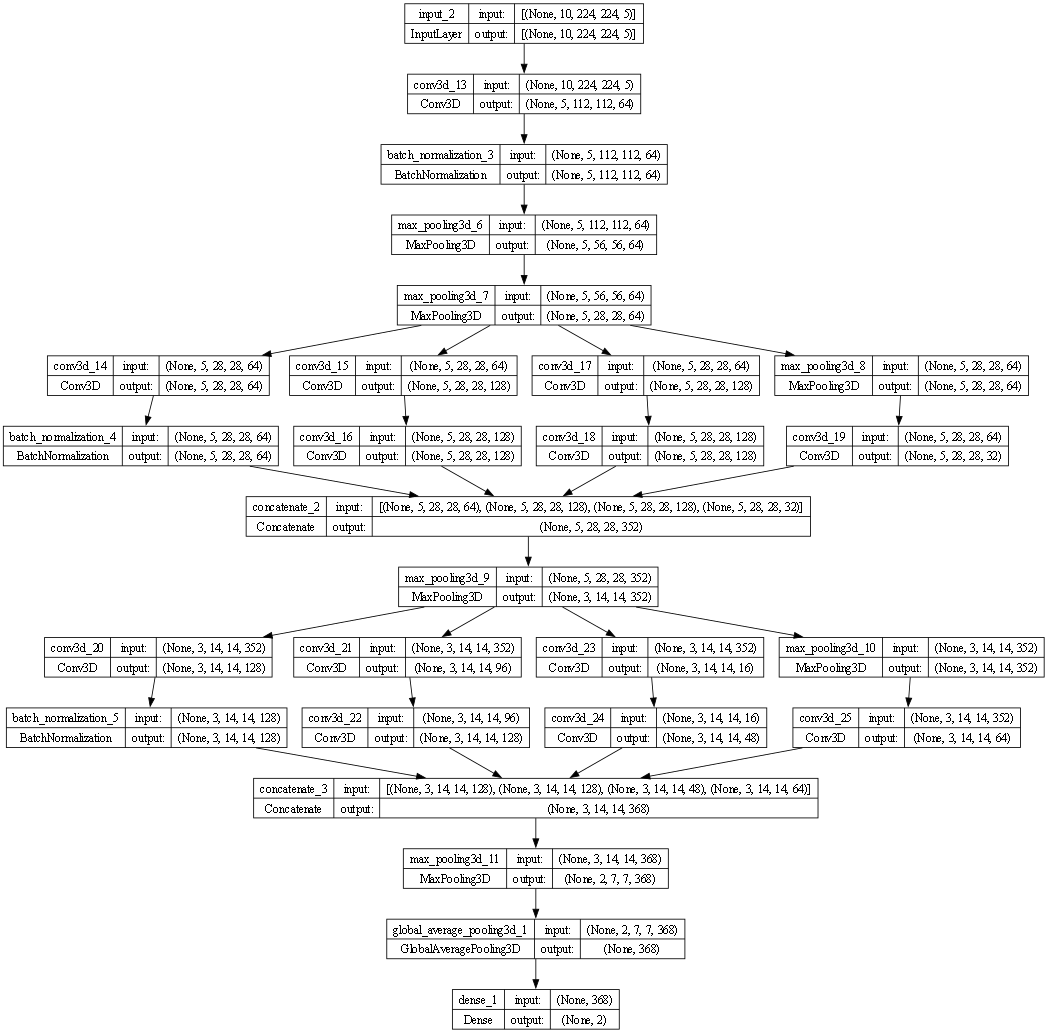

In [27]:
# Visualize the model
import tensorflow.keras as keras
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 5)]                                                            
                                                                                                  
 conv3d_13 (Conv3D)             (None, 5, 112, 112,  109824      ['input_2[0][0]']                
                                 64)                                                              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 5, 112, 112,  256        ['conv3d_13[0][0]']              
 rmalization)                    64)                                                        

## Train the model

In [29]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [30]:
history = model.fit(x=train_ds, epochs=60, validation_data=val_ds)

Epoch 1/60
22/22 [==============================] - 77s 3s/step - loss: 7.1942 - accuracy: 0.6897 - val_loss: 7.1361 - val_accuracy: 0.4000
Epoch 2/60
22/22 [==============================] - 66s 3s/step - loss: 6.8597 - accuracy: 0.7931 - val_loss: 6.9148 - val_accuracy: 0.6000
Epoch 3/60
22/22 [==============================] - 64s 3s/step - loss: 6.5345 - accuracy: 0.8621 - val_loss: 6.7603 - val_accuracy: 0.6000
Epoch 4/60
22/22 [==============================] - 63s 3s/step - loss: 6.4997 - accuracy: 0.8103 - val_loss: 6.5563 - val_accuracy: 0.6800
Epoch 5/60
22/22 [==============================] - 59s 3s/step - loss: 6.3732 - accuracy: 0.7586 - val_loss: 6.4224 - val_accuracy: 0.6000
Epoch 6/60
22/22 [==============================] - 60s 3s/step - loss: 6.1126 - accuracy: 0.8103 - val_loss: 6.2704 - val_accuracy: 0.6000
Epoch 7/60
22/22 [==============================] - 56s 3s/step - loss: 5.9692 - accuracy: 0.8276 - val_loss: 6.2044 - val_accuracy: 0.6000
Epoch 8/60
22/22 [==

In [31]:
# model.save('violence_detection_v1_temp.h5')
import tensorflow.keras as keras


# model = keras.models.load_model('violence_detection_v1_temp2.h5')
model.save('violence_detection_v1_temp2.h5')
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 8s 3s/step - loss: 2.5689 - accuracy: 0.8750


{'loss': 2.5688672065734863, 'accuracy': 0.875}

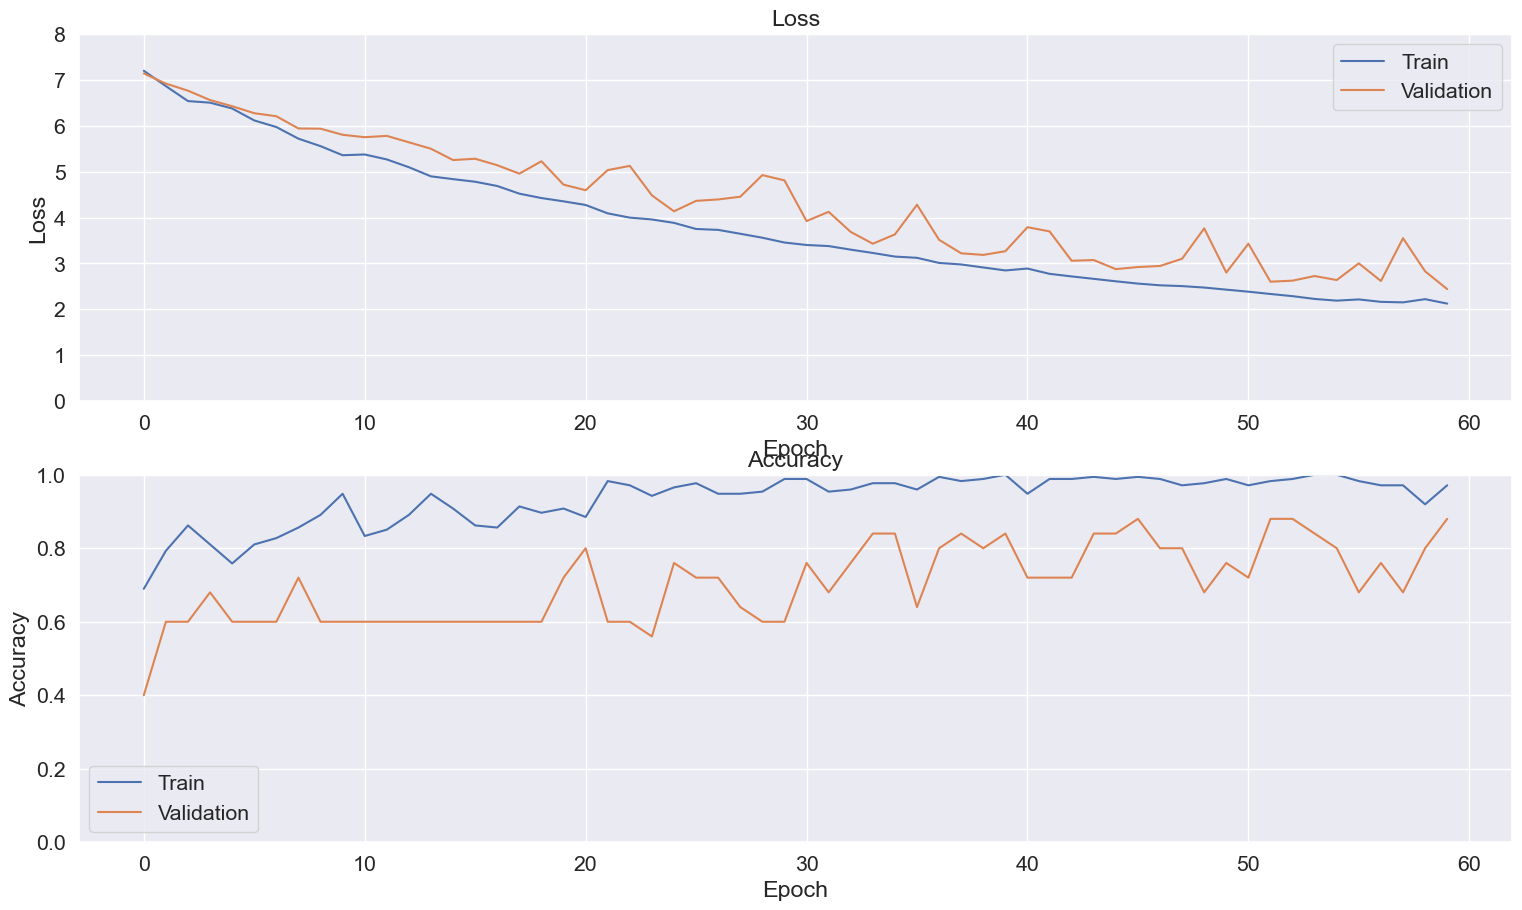

In [32]:
import matplotlib.pyplot as plt
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="train")
    ax1.plot(history.history["val_loss"], label="test")
    ax1.set_ylabel("Loss")

    # Determine upper bound of y-axis
    max_loss = max(history.history["loss"] + history.history["val_loss"])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"])

    # Plot accuracy
    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="train")
    ax2.plot(history.history["val_accuracy"], label="test")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"])

    plt.show()


plot_history(history)

In [33]:
def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


import seaborn as sns


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


fg = FrameGenerator(pathlib.Path(subset_paths["train"]), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())



22/22 [==============================] - 39s 2s/step


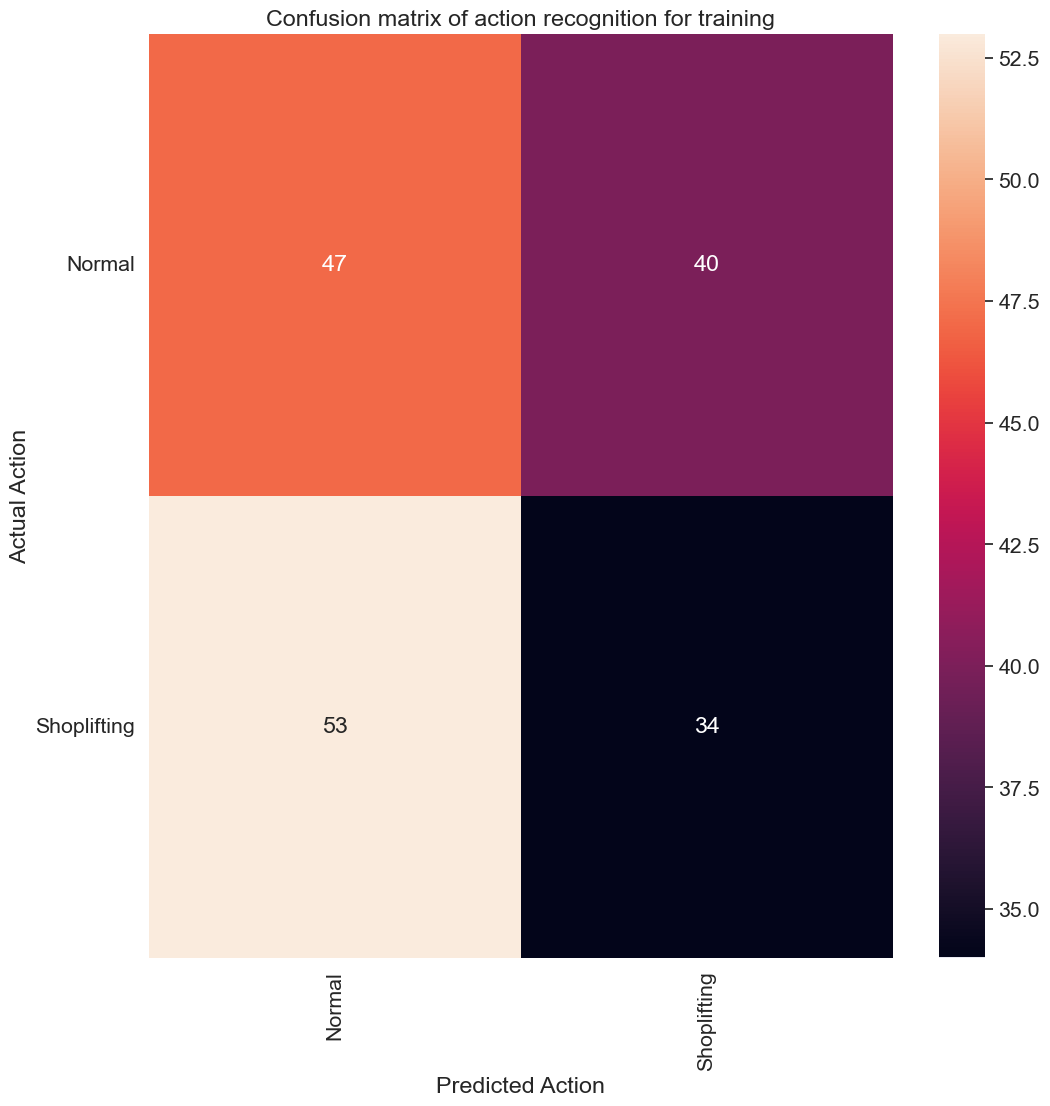

In [34]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, "training")

4/4 [==============================] - 6s 1s/step


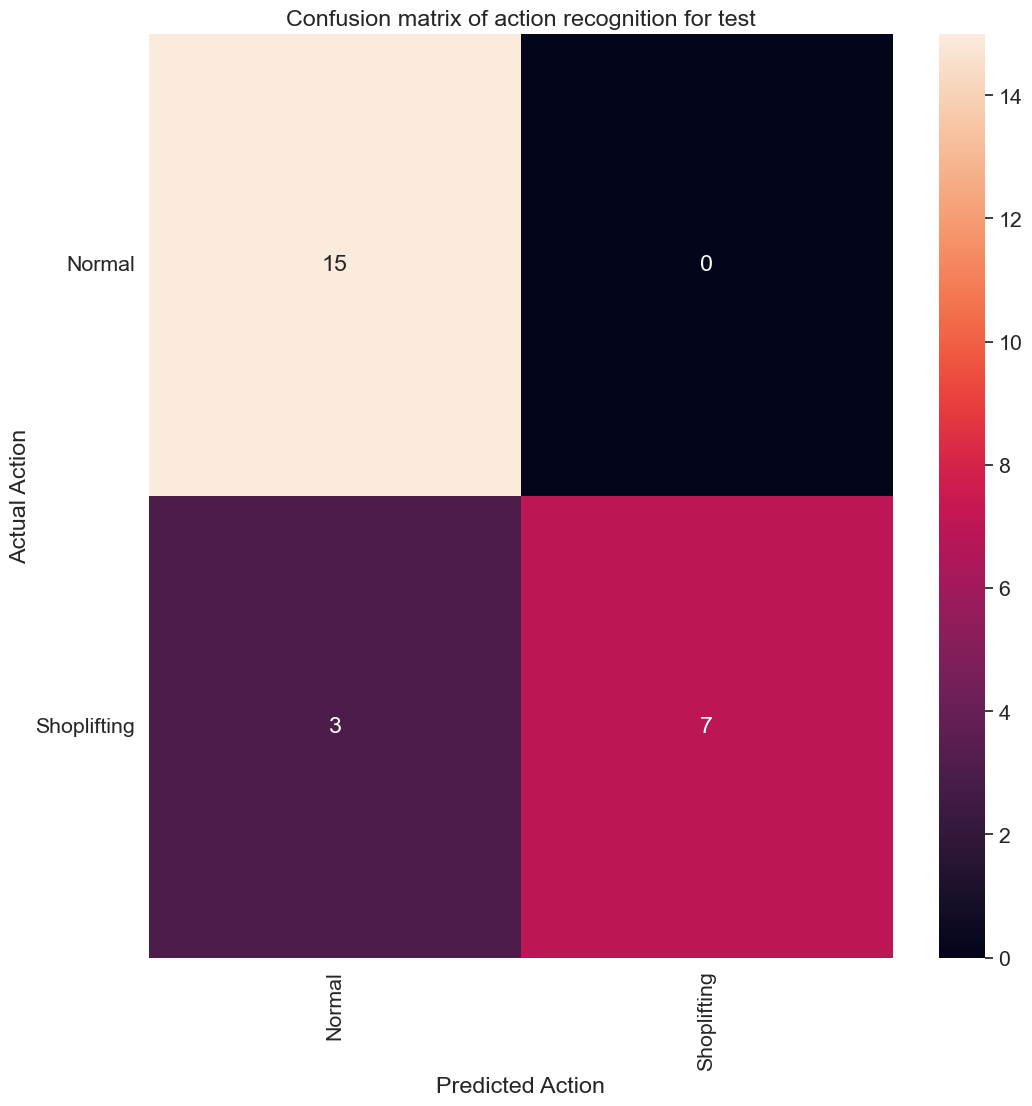

In [35]:
actual, predicted = get_actual_predicted_labels(val_ds)
plot_confusion_matrix(actual, predicted, labels, "test")

In [36]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]  # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i]  # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp)  # Precision

        recall[labels[i]] = tp[i] / (tp[i] + fn)  # Recall

    return precision, recall


precision, recall = calculate_classification_metrics(
    actual, predicted, labels
)  # Test dataset
precision

{'Normal': 0.8333333333333334, 'Shoplifting': 1.0}

In [37]:
recall

{'Normal': 1.0, 'Shoplifting': 0.7}

In [40]:
history = model.fit(
    x=train_ds,
    epochs=40,
    validation_data=val_ds,
)

Epoch 1/40


22/22 [==============================] - 59s 3s/step - loss: 1.1729 - accuracy: 0.9828 - val_loss: 3.2561 - val_accuracy: 0.6000
Epoch 2/40
22/22 [==============================] - 60s 3s/step - loss: 1.2117 - accuracy: 0.9828 - val_loss: 1.6513 - val_accuracy: 0.8400
Epoch 3/40
22/22 [==============================] - 59s 3s/step - loss: 1.1338 - accuracy: 0.9943 - val_loss: 1.5744 - val_accuracy: 0.8800
Epoch 4/40
22/22 [==============================] - 60s 3s/step - loss: 1.1252 - accuracy: 1.0000 - val_loss: 1.3796 - val_accuracy: 0.8000
Epoch 5/40
22/22 [==============================] - 60s 3s/step - loss: 1.0960 - accuracy: 1.0000 - val_loss: 1.6236 - val_accuracy: 0.8400
Epoch 6/40
22/22 [==============================] - 59s 3s/step - loss: 1.0771 - accuracy: 1.0000 - val_loss: 1.5391 - val_accuracy: 0.8400
Epoch 7/40
22/22 [==============================] - 60s 3s/step - loss: 1.0658 - accuracy: 1.0000 - val_loss: 1.4032 - val_accuracy: 0.8400
Epoch 8/40
22/22 [=============

In [41]:
#  load model
# model.save("violence_detection_v1_temp3.h5")
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 7s 3s/step - loss: 1.2443 - accuracy: 0.9167


{'loss': 1.244254231452942, 'accuracy': 0.9166666865348816}

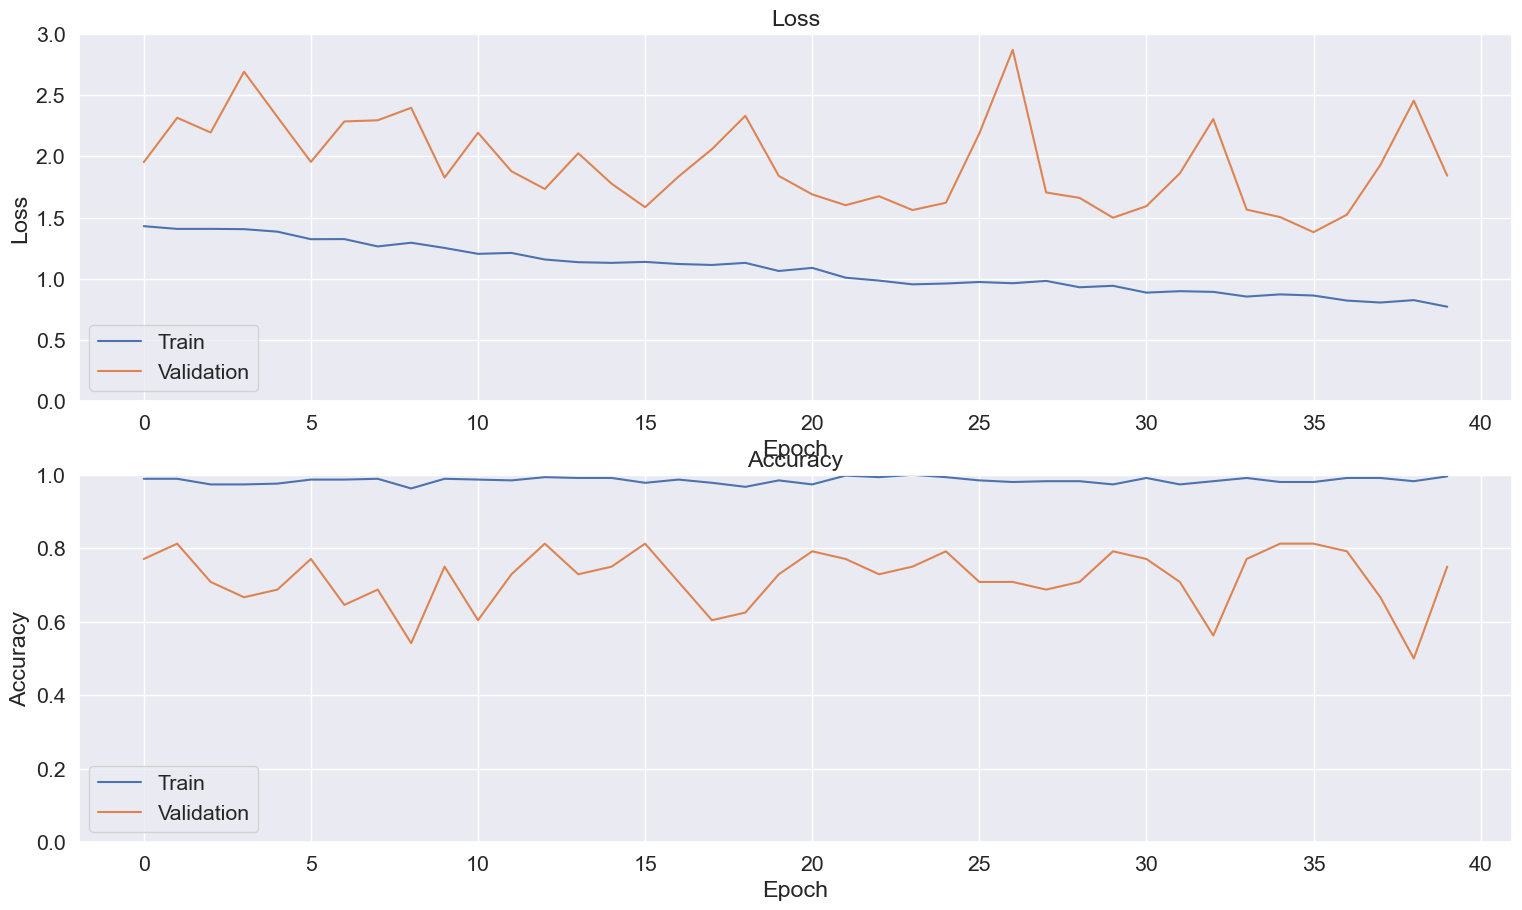

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="train")
    ax1.plot(history.history["val_loss"], label="test")
    ax1.set_ylabel("Loss")

    # Determine upper bound of y-axis
    max_loss = max(history.history["loss"] + history.history["val_loss"])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"])

    # Plot accuracy
    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="train")
    ax2.plot(history.history["val_accuracy"], label="test")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"])

    plt.show()


plot_history(history)

57/57 [==============================] - 102s 2s/step


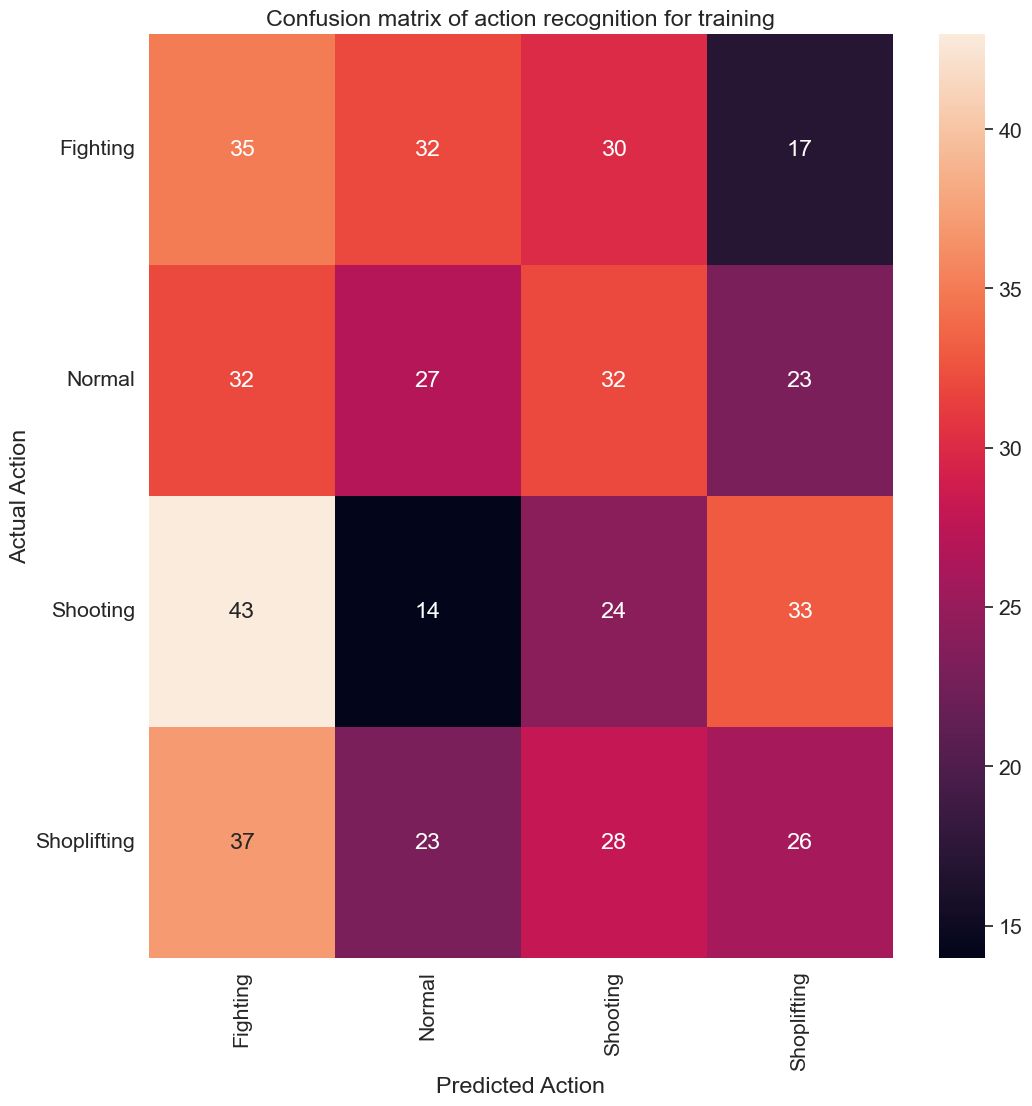

In [ ]:
def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


import seaborn as sns


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


fg = FrameGenerator(pathlib.Path(subset_paths["train"]), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, "training")


6/6 [==============================] - 11s 2s/step


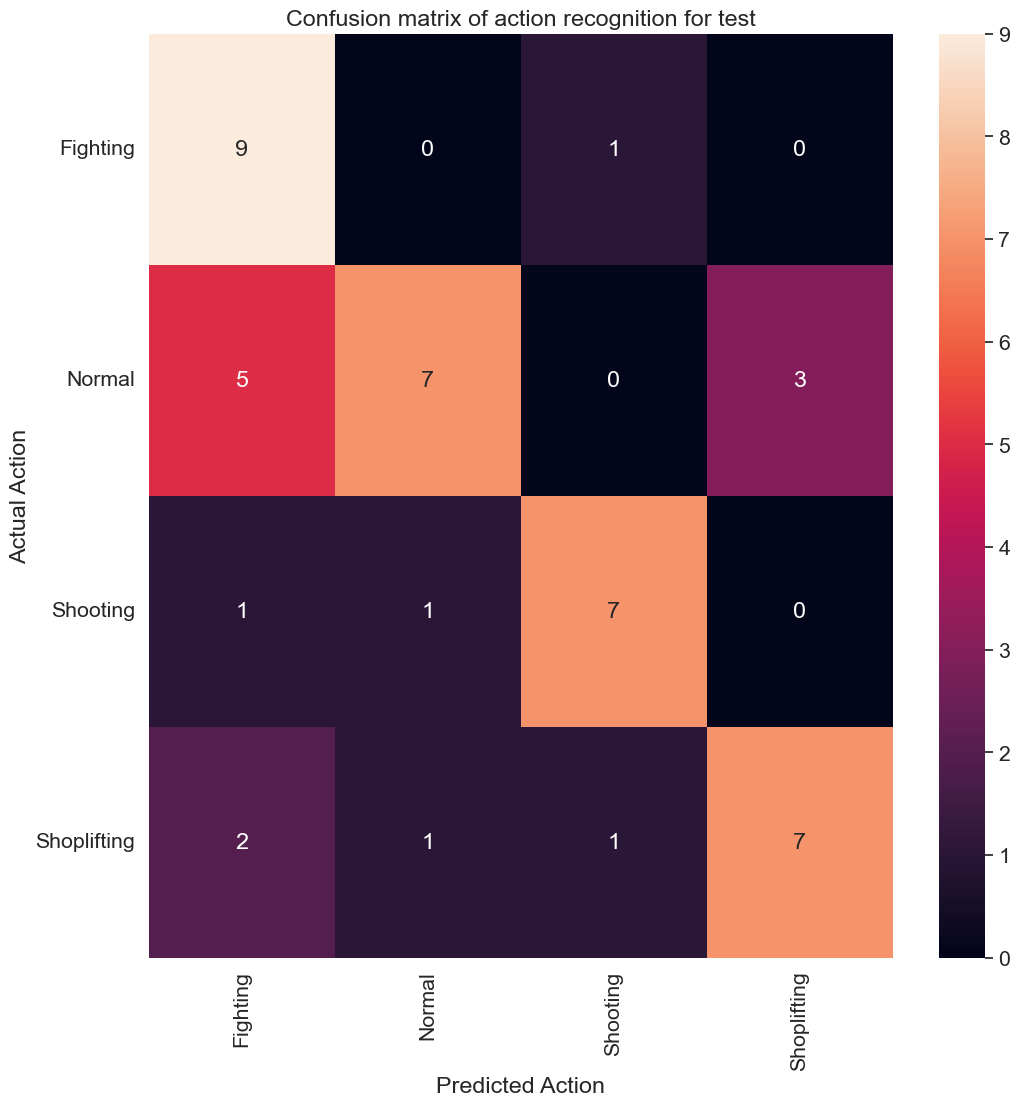

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, "test")



In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]  # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i]  # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp)  # Precision

        recall[labels[i]] = tp[i] / (tp[i] + fn)  # Recall

    return precision, recall


precision, recall = calculate_classification_metrics(
    actual, predicted, labels
)  # Test dataset
precision

{'Fighting': 0.5294117647058824,
 'Normal': 0.7777777777777778,
 'Shooting': 0.7777777777777778,
 'Shoplifting': 0.7}

In [ ]:
precision

{'Fighting': 0.5294117647058824,
 'Normal': 0.7777777777777778,
 'Shooting': 0.7777777777777778,
 'Shoplifting': 0.7}

In [ ]:
recall

{'Fighting': 0.9,
 'Normal': 0.4666666666666667,
 'Shooting': 0.7777777777777778,
 'Shoplifting': 0.6363636363636364}

In [ ]:
model.save("violence_detection_temp_v5.h5")

In [ ]:
model.evaluate(test_ds, return_dict=True)

9/9 [==============================] - 14s 2s/step - loss: 2.2305 - accuracy: 0.6429


{'loss': 2.230539560317993, 'accuracy': 0.6428571343421936}

In [ ]:
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="train")
    ax1.plot(history.history["val_loss"], label="test")
    ax1.set_ylabel("Loss")

    # Determine upper bound of y-axis
    max_loss = max(history.history["loss"] + history.history["val_loss"])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"])

    # Plot accuracy
    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="train")
    ax2.plot(history.history["val_accuracy"], label="test")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"])

    plt.show()


plot_history(history)

In [ ]:
def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


import seaborn as sns


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


fg = FrameGenerator(pathlib.Path(subset_paths["train"]), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, "training")
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, "test")


def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]  # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i]  # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp)  # Precision

        recall[labels[i]] = tp[i] / (tp[i] + fn)  # Recall

    return precision, recall


precision, recall = calculate_classification_metrics(
    actual, predicted, labels
)  # Test dataset
recall
precision

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

In [20]:
model.save("model_class6_v4.h5")

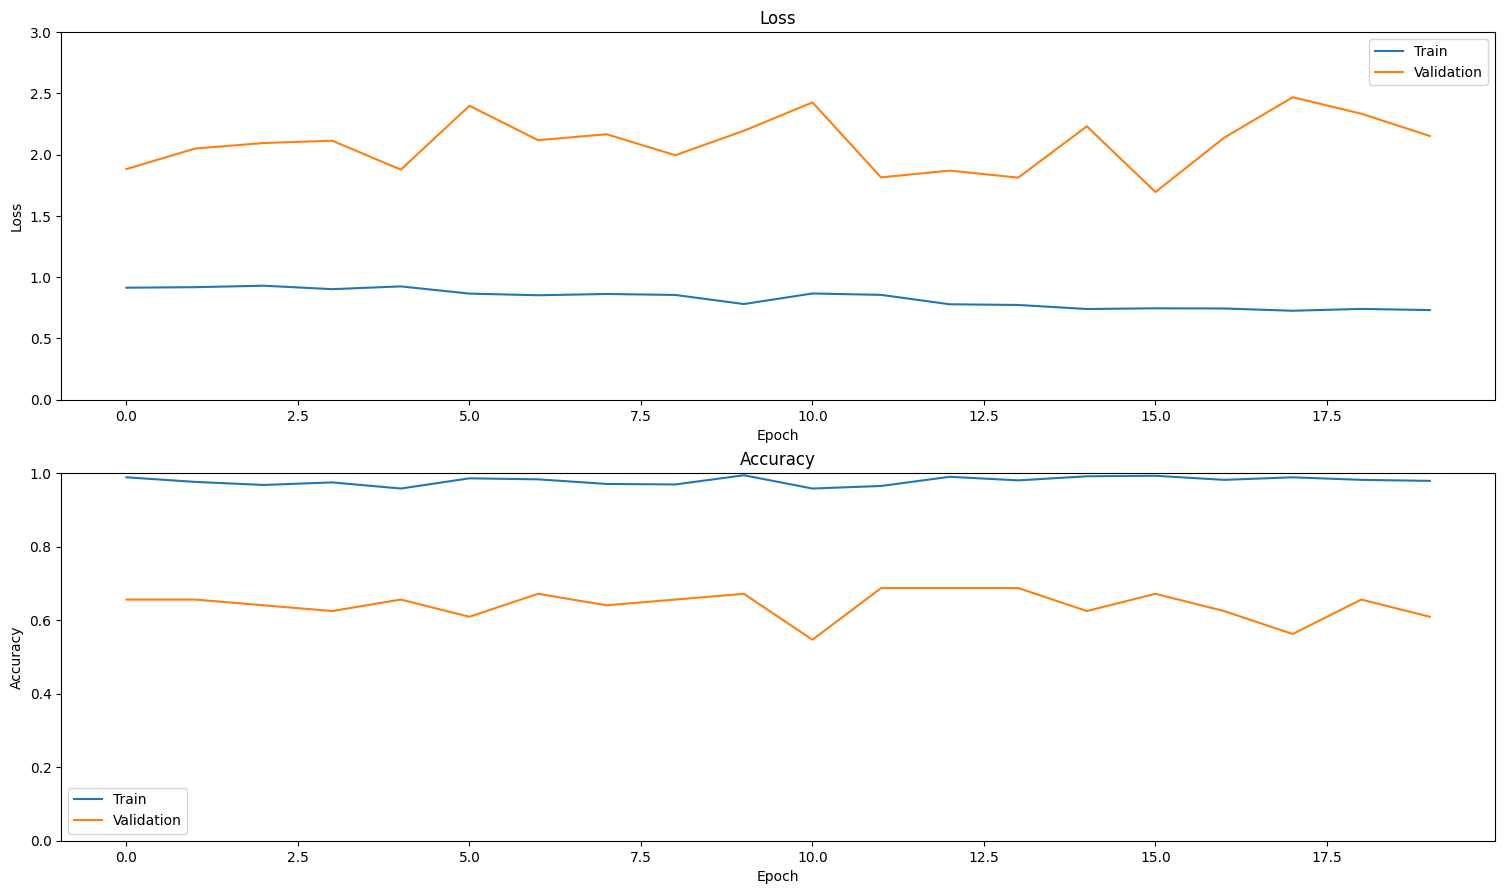

In [21]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

In [22]:
model.evaluate(test_ds, return_dict=True)

9/9 [==============================] - 13s 1s/step - loss: 2.2206 - accuracy: 0.5857


{'loss': 2.2205965518951416, 'accuracy': 0.5857142806053162}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [18]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted
import seaborn as sns
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
fg = FrameGenerator(pathlib.Path(subset_paths["train"]), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, "training")
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, "test")
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]  # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i]  # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp)  # Precision

        recall[labels[i]] = tp[i] / (tp[i] + fn)  # Recall

    return precision, recall
precision, recall = calculate_classification_metrics(
    actual, predicted, labels
)  # Test dataset
recall
precision

     48/Unknown - 149s 3s/step

KeyboardInterrupt: 

The precision and recall values for each class can also be calculated using a confusion matrix.

In [50]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [51]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

C:\Users\HP\AppData\Local\Temp\ipykernel_21860\791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [52]:
precision

{'Abuse': 1.0,
 'Fighting': 0.4,
 'Normal': 0.75,
 'Shooting': 0.4166666666666667,
 'Shoplifting': nan,
 'Vandalism': 0.5}

In [53]:
recall

{'Abuse': 0.4444444444444444,
 'Fighting': 1.0,
 'Normal': 0.3,
 'Shooting': 0.5555555555555556,
 'Shoplifting': 0.0,
 'Vandalism': 0.6}

# Real-time Analysis

### Instant

In [4]:
frame_buffer = []
# Define constants
HEIGHT = 224
WIDTH = 224
NUM_FRAMES = 10
# Define the preprocess_frame function
def preprocess_frame(frame):
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = frame / 255.0  # Normalize pixel values to be between 0 and 1
    return frame

# Define the predict_action function
def predict_action(frames):
    # Assuming frames is a list of 10 frames
    preprocessed_frames = [preprocess_frame(frame) for frame in frames]
    expanded_frames = np.expand_dims(preprocessed_frames, axis=0)
    predictions = model.predict(expanded_frames)
    action_label = np.argmax(predictions)
    return action_label

In [5]:
# Open the video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Add the frame to the buffer
    frame_buffer.append(preprocessed_frame)

    # Keep the buffer size to NUM_FRAMES
    if len(frame_buffer) == NUM_FRAMES:
        # Make prediction using the buffered frames
        action_label = predict_action(frame_buffer)

        # Do something with the predicted action label q(print, display, etc.)
        print("Predicted Action:", action_label)

        # Display the frame if needed
        cv2.imshow('Frame', frame)

        # Remove the oldest frame from the buffer
        frame_buffer.pop(0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 3s 3s/step
Predicted Action: 0
1/1 [==============================] - 0s 43ms/step
Predicted Action: 0
1/1 [==============================] - 0s 37ms/step
Predicted Action: 0
1/1 [==============================] - 0s 36ms/step
Predicted Action: 0
1/1 [==============================] - 0s 68ms/step
Predicted Action: 0
1/1 [==============================] - 0s 46ms/step
Predicted Action: 0
1/1 [==============================] - 0s 47ms/step
Predicted Action: 0
1/1 [==============================] - 0s 47ms/step
Predicted Action: 0
1/1 [==============================] - 0s 38ms/step
Predicted Action: 0
1/1 [==============================] - 0s 38ms/step
Predicted Action: 0
1/1 [==============================] - 0s 40ms/step
Predicted Action: 0
1/1 [==============================] - 0s 47ms/step
Predicted Action: 0
1/1 [==============================] - 0s 50ms/step
Predicted Action: 0
1/1 [==============================] - 0s 28ms/step
Predicted Acti

In [6]:
import cv2
import numpy as np

def load_and_preprocess_video(video_path, target_shape=(224, 224), num_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to target shape
        frame = cv2.resize(frame, target_shape)
        # Normalize pixel values to the range [0, 1]
        frame = frame / 255.0

        frames.append(frame)

    cap.release()

    # Pad or truncate frames to have the desired number of frames (num_frames)
    frames = frames[:num_frames] + [np.zeros_like(frames[0])] * (num_frames - len(frames))

    return np.array(frames)

# Usage
video_path = 'videoplayback (1).mp4'
frames = load_and_preprocess_video(video_path, target_shape=(224, 224), num_frames=10)
frames = frames[np.newaxis, ...]  # Add batch dimension
predictions = model(frames)
print(predictions)
predicted_class = np.argmax(predictions)
print(f"The predicted class for the video is: {predicted_class}")


tf.Tensor([[0.48217958 0.5178204 ]], shape=(1, 2), dtype=float32)
The predicted class for the video is: 1


### Record video

In [ ]:
# Define the preprocess_frame function
def preprocess_frame(frame):
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = frame / 255.0  # Normalize pixel values to be between 0 and 1
    return frame

# Define the predict_action function
def predict_action(frames):
    # Assuming frames is a numpy array of shape (BATCH_SIZE, NUM_FRAMES, HEIGHT, WIDTH, 3)
    preprocessed_frames = frames / 255.0  # Normalize pixel values to be between 0 and 1
    predictions = model.predict(preprocessed_frames)
    action_labels = np.argmax(predictions, axis=1)
    return action_labels

In [72]:
import cv2
import numpy as np
from datetime import datetime, timedelta
# Define the preprocess_frame function
def preprocess_frame(frame):
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = frame / 255.0  # Normalize pixel values to be between 0 and 1
    return frame

# Define the predict_action function
def predict_action(frames):
    # Assuming frames is a numpy array of shape (BATCH_SIZE, NUM_FRAMES, HEIGHT, WIDTH, 3)
    preprocessed_frames = frames / 255.0  # Normalize pixel values to be between 0 and 1
    predictions = model.predict(preprocessed_frames)
    action_labels = np.argmax(predictions, axis=1)
    return action_labels

In [82]:
# Constants
HEIGHT = 224
WIDTH = 224
NUM_FRAMES = 10
BATCH_SIZE = 5  # Adjust the batch size as needed
VIDEO_DURATION_SECONDS = 10
VIDEO_FPS = 30

# Open the video capture
cap = cv2.VideoCapture(0)

# Create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, VIDEO_FPS, (WIDTH, HEIGHT))
if not output_video.isOpened():
    print("Error opening VideoWriter")

frame_buffer = []

# Record the entire video
start_time = datetime.now()
while (datetime.now() - start_time).seconds < VIDEO_DURATION_SECONDS:
    ret, frame = cap.read()
    if not ret:
        print("nothing")
        break

    # Save the frame to the output video
    output_video.write((frame * 255).astype(np.uint8))

# Release the video capture and writer for recording
cap.release()
output_video.release()


In [88]:

# Open the recorded video for processing
recorded_video = cv2.VideoCapture('Stealing013_x264.mp4')

# Process the frames
while True:
    ret, frame = recorded_video.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Add the frame to the buffer
    frame_buffer.append(preprocessed_frame)

    # Check if there are enough frames for a batch
    if len(frame_buffer) == NUM_FRAMES * BATCH_SIZE:
        # Prepare the frames for prediction
        batch_frames = np.array(frame_buffer).reshape((BATCH_SIZE, NUM_FRAMES, HEIGHT, WIDTH, 3))

        # Make prediction using the batched frames
        action_labels = predict_action(batch_frames)

        # Do something with the predicted action labels (print, display, etc.)
        print("Predicted Actions:", action_labels)

        # Clear the buffer
        frame_buffer = []

# Release the recorded video capture
recorded_video.release()
cv2.destroyAllWindows()

MemoryError: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64